# Analysis of the autism data

In [2]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


# developpe dataset task

In [69]:
from autismDataset import Dataset


df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")
data = Dataset(df=df, 
               missing_data_handling='encoding', 
               imputation_method='without', 
               proportion_train=1)

data.reset()
data.filter(administration={'order': 'first', 
                             'completed': True}, 
            clinical={'diagnosis': [0, 1]}, 
            #demographics={'age':[18, 36], 
            #              'sex': 1},
            features={'having':['gaze', 'touch']})

#data.plot()

Predicting diagnosis based on 18 features
Removing 149/2298 incomplete administrations.
Removing 953/2149 keeping first admin.
Removing 77/1196 keeping only subject with diagnosis: [0, 1].
1119 administrations left.


,id
diagnosis,
0.0,930
1.0,189


In [68]:
data.features_name = data.features_name[:2]

Predicting diagnosis based on 2 features


In [75]:
exp = Experiments(data.dataset_name,
                  dataset=data, 
                approach='nam', 
                proportion_train=PROPORTION_TRAIN, 
                resolution=RESOLUTION, 
                bandwidth=BANDWIDTH, 
                use_missing_indicator_variables=False, #DEFAULT_USE_INDICATOR_VARIABLE,
                previous_experiment=None,        
                verbosity=1, 
                debug=True, 
                save_experiment=False)

In [76]:
self = exp
num_cv = 16
NAM_DEFAULT_PARAMETERS['training']['max_epochs'] = 2
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from model.neural_additive_models.nam import NAM
from model.neural_additive_models.visualization import plot_roc_curves_nam, plot_shape_functions
from model.neural_additive_models.utils import train_model, eval_model
from model.neural_additive_models.dataset import TabularData
import torch

cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=0)
print('Performing {} fold cross-validation.'.format(num_cv)) if self.verbosity > 1 else None
    
replicates_results = []
best_roc_auc = 0
NAM_DEFAULT_PARAMETERS['model']['num_features'] = len(self.features_name)

for i in range(2):#NAM_DEFAULT_PARAMETERS['num_replicates']):      
    #print('\t===== Replicate no. {} =====\n'.format(i + 1)) if (self.debug or self.verbosity > 1)  else None
    

    y_pred_all = np.zeros(self.dataset._y.shape[0]).astype('float32') 
    feature_net_values_all = np.zeros((self.dataset._y.shape[0], len(self.features_name))).astype('float32') 

    test_dict = {k:np.zeros(self.dataset.num_samples) for k in range(X_test.shape[1])}
    test_dict['y_true'] = np.zeros(self.dataset.num_samples)
    for idx_split, (train, test) in enumerate(cv.split(self.dataset._X, self.dataset._y)):
    
        # Init data
        X_train, X_test, y_train, y_test = self._init_train_test(train=train, test=test, return_y=True)

        # Create the df associated to the test sample 
        for k in range(X_test.shape[1]):
            test_dict[k][test] = X_test[:,k]
            

        #test_dict = {i:X_test[:,i] for i in range(X_test.shape[1])}
        
        test_dict['y_true'][test] = y_test
        test_df = pd.DataFrame.from_dict(test_dict);test_df.columns = self.features_name + ["y_true"]

        # Create the PyTorch Datasets
        data_train, data_test = TabularData(X=X_train, y=y_train), TabularData(X=X_test, y=y_test) 

        # Init. the model
        model = NAM(**NAM_DEFAULT_PARAMETERS['model'])
        model = model.double()

        train_model(model, data_train, verbosity=self.verbosity, **NAM_DEFAULT_PARAMETERS['training'])
        y_pred_all[test], feature_net_values_all[test] = eval_model(model, data_test)

        
    res = (pd.DataFrame(feature_net_values_all, columns = self.features_name, index=test_df.index)
                .add_suffix('_partial')
                .join(test_df)
                .assign(y_pred = y_pred_all)
                .assign(replicate = i))

    replicates_results.append(res)

    # Save best model by computing auroc
    y_true = res['y_true'].to_numpy(); y_pred = res['y_pred'].to_numpy()
    fpr_auc, tpr_auc, _ = roc_curve(y_true, y_pred)      
    roc_auc = auc(fpr_auc, tpr_auc)  
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc

        if self.save_experiment:
            torch.save(model.state_dict(), os.path.join(self.experiment_path, 'best_model.pt'))
        else:
            torch.save(model.state_dict(), os.path.join(DATA_DIR, 'tmp', 'best_model.pt'))

# Finally load the best model

self.model = NAM(**NAM_DEFAULT_PARAMETERS['model'])
self.model = self.model.double()
if self.save_experiment:
    self.model.load_state_dict(torch.load(os.path.join(self.experiment_path, 'best_model.pt')))
else:
    self.model.load_state_dict(torch.load(os.path.join(DATA_DIR, 'tmp', 'best_model.pt')))

self.model.eval()

pd.concat(replicates_results)

KeyError: 2

In [ ]:
exp.fit_predict(num_cv=16)

Encoding 1119 (train) and 0 (test) missing values with -5.
	===== Replicate no. 1 =====

Epoch: 1/2;	 Batch: 1/66;	 Err: 2.789
Epoch: 1/2;	 Batch: 2/66;	 Err: 3.968
Epoch: 1/2;	 Batch: 3/66;	 Err: 3.363
Epoch: 1/2;	 Batch: 4/66;	 Err: 4.976
Epoch: 1/2;	 Batch: 5/66;	 Err: 3.670
Epoch: 1/2;	 Batch: 6/66;	 Err: 1.696
Epoch: 1/2;	 Batch: 7/66;	 Err: 2.658
Epoch: 1/2;	 Batch: 8/66;	 Err: 2.428
Epoch: 1/2;	 Batch: 9/66;	 Err: 2.265
Epoch: 1/2;	 Batch: 10/66;	 Err: 1.024
Epoch: 1/2;	 Batch: 11/66;	 Err: 1.539
Epoch: 1/2;	 Batch: 12/66;	 Err: 1.902
Epoch: 1/2;	 Batch: 13/66;	 Err: 1.595
Epoch: 1/2;	 Batch: 14/66;	 Err: 2.085
Epoch: 1/2;	 Batch: 15/66;	 Err: 1.502
Epoch: 1/2;	 Batch: 16/66;	 Err: 1.338
Epoch: 1/2;	 Batch: 17/66;	 Err: 1.397
Epoch: 1/2;	 Batch: 18/66;	 Err: 1.247
Epoch: 1/2;	 Batch: 19/66;	 Err: 1.779
Epoch: 1/2;	 Batch: 20/66;	 Err: 1.703
Epoch: 1/2;	 Batch: 21/66;	 Err: 1.433
Epoch: 1/2;	 Batch: 22/66;	 Err: 1.406
Epoch: 1/2;	 Batch: 23/66;	 Err: 1.402
Epoch: 1/2;	 Batch: 24/

,Accuracy,F1 score (2 PPVxTPR/(PPV+TPR)),Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV)
0,0.828,0.157,0.144,0.095,0.976,0.45,0.842,0.905,0.55,0.158


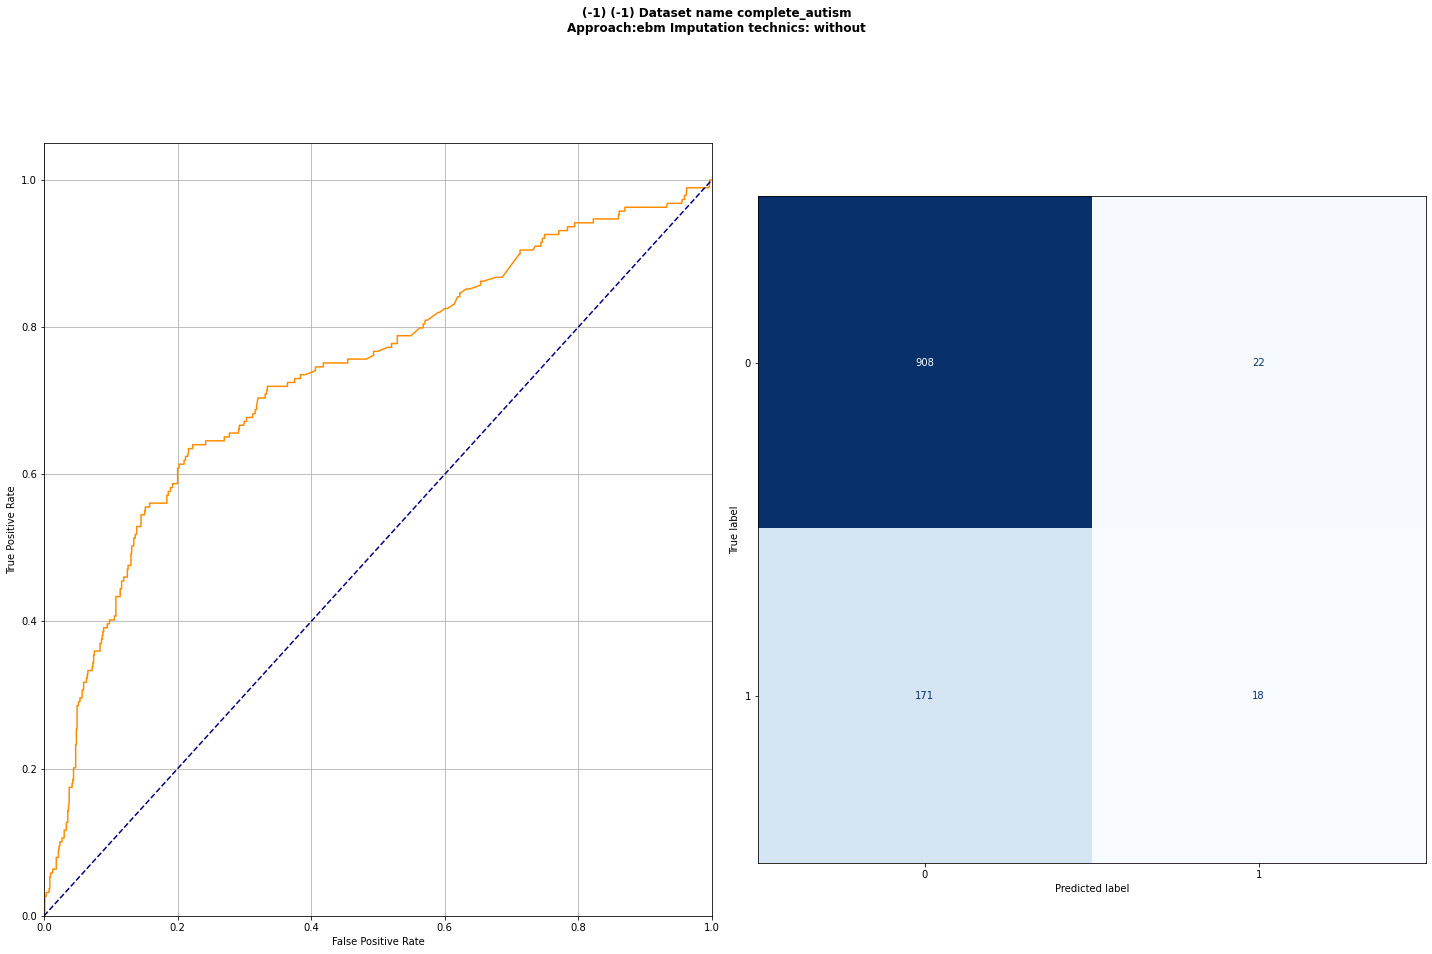

<!-- http://127.0.0.1:7001/140467457219472/ -->

In [147]:
exp.plot()

In [27]:
self=exp

y_true = self.dataset.y_test.squeeze()
y_pred = self.dataset.y_pred

y_true

array([0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 3., 1.,
       0., 3., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 2., 0., 3., 0., 0., 1., 0., 3., 3., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 1., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 3., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0.

In [14]:
data.features_name + ['Z_' + feat for feat in data.features_name]

['age',
 'sex',
 'ethnicity',
 'race',
 'primary_education',
 'diagnosis',
 'asd_yn',
 'mullen_el',
 'mullen_fm',
 'mullen_rl',
 'mullen_vr',
 'mullen_elc_std',
 'ados_total',
 'ados_rrb',
 'ados_sa',
 'srs_total_tscore',
 'srs_social_awareness_tscore',
 'srs_social_motivation_tscore',
 'cbcl_scaleIV_score',
 'cbcl_asd_score',
 'mchat_total',
 'mchat_final',
 'mchat_result',
 'BB_gaze_percent_right',
 'BB_gaze_silhouette_score',
 'S_gaze_percent_right',
 'S_gaze_silhouette_score',
 'FP_gaze_speech_correlation',
 'FP_gaze_silhouette_score',
 'inv_S_gaze_percent_right',
 'mean_gaze_percent_right',
 'gaze_silhouette_score',
 'proportion_of_name_call_responses',
 'average_response_to_name_delay',
 'FB_postural_sway',
 'FB_postural_sway_derivative',
 'DIGC_postural_sway',
 'DIGC_postural_sway_derivative',
 'DIGRRL_postural_sway',
 'DIGRRL_postural_sway_derivative',
 'ST_postural_sway',
 'ST_postural_sway_derivative',
 'MP_postural_sway',
 'MP_postural_sway_derivative',
 'PB_postural_sway',


In [17]:
num_cv = 16
self=data

"""
Evaluate a sklearn model for the data X with ground truth labels y
"""
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

y_pred_score = -1*np.ones_like(self._y).astype('float32')  # init prediction scores 

if num_cv>0:   # use cross-validation.
    cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=0)
    # print('Performing {} fold cross-validation.'.format(num_cv))
    for i, (train, test) in enumerate(cv.split(X, y)):
        if False and 'xgboost' in model.name:
            ratio_train = float(np.sum(y[train] == 0)) / np.sum(y[train]==1)
            model.model.scale_pos_weight = ratio_train

        if False and 'xgboost' in model.name:
            kwargs['eval_set'] = [(X[test], y[test])]

        # Fit classifier
        model.fit(X[train], y[train], balanced=True, **kwargs)
        # Predict samples on the test set
        y_pred_score[test] = model.predict_proba(X[test])

else:  # just fit and predict the data (just for baseline, DON'T USE TO ASSES PERFORMANCE)
    model.fit(X, y, balanced= True)
    y_pred_score = model.predict_proba(X)

NameError: name 'X' is not defined

# Load and analysis df

In [109]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

In [110]:
df['diagnosis']

0        ASD
1        ASD
2        ASD
3       DDLD
4        ASD
        ... 
2293      TD
2294      TD
2295      TD
2296      TD
2297      TD
Name: diagnosis, Length: 2298, dtype: object

In [5]:
print(len(df))
df.groupby('diagnosis').count()

2298


,id,language,app_version,subject,administration,features_extracted,face_tracking,age,date,time,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,PB_postural_sway,PB_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage
diagnosis,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ADHD,83,83,83,83,83,83,83,83,83,0,83,83,83,83,0,0,0,0,0,0,20,20,18,3,3,3,1,1,1,1,1,82,81,82,82,81,81,83,53,83,83,82,82,82,82,82,82,82,82,0,0,82,82,82,82,82,82,81,81,81,81,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,50,50,72
ASD,310,310,310,310,310,310,310,310,310,96,310,310,310,310,0,60,60,60,60,60,211,211,211,45,45,45,44,44,141,141,141,247,246,258,258,235,231,262,178,263,262,255,255,250,250,258,258,253,253,0,0,249,249,243,243,240,240,237,237,234,234,182,175,175,175,175,182,175,175,175,173,173,171,171,175,175,175,175,138,138,182
DDLD,54,54,54,54,54,54,54,54,54,37,54,54,54,54,0,17,17,17,17,17,17,17,17,15,15,15,14,14,54,54,54,37,37,41,41,29,29,44,26,43,43,45,45,44,44,41,41,40,40,2,2,37,37,37,37,32,32,28,28,29,29,16,14,14,14,14,16,14,14,14,14,14,14,14,14,14,14,14,11,11,16
TD,1851,1851,1851,1851,1851,1851,1851,1851,1851,1377,1851,1851,1851,1849,0,4,4,4,4,4,4,4,4,251,251,251,440,440,1075,1075,1075,1027,1023,1087,1085,966,960,1146,591,1163,1160,1120,1120,1094,1092,1088,1087,1070,1069,436,435,1028,1028,1012,1012,1005,1004,583,583,963,963,405,378,378,372,372,405,378,378,378,369,369,371,371,378,378,372,372,307,307,405


In [31]:
df = pd.read_csv("/Users/samperochon/Duke/work/notes_on_stats/df_all.csv")

# Merge postural sway variables into social and non-social 
def compute_cva_condensed_variables(df_in=None):
    df = df_in.copy()
    S_postural_sway = df[['ST_postural_sway', 'BB_postural_sway', 'RT_postural_sway', 'MML_postural_sway', 'FP_postural_sway']].mean(axis=1)
    NS_postural_sway = df[['DIGC_postural_sway', 'DIGRRL_postural_sway', 'FB_postural_sway', 'MP_postural_sway']].mean(axis=1)
    df['S_postural_sway'] = S_postural_sway
    df['NS_postural_sway'] = NS_postural_sway

    # Merge silhouette scores
    gaze_silhouette_score = df[['BB_gaze_silhouette_score','S_gaze_silhouette_score','FP_gaze_silhouette_score']].mean(axis=1)
    df['gaze_silhouette_score'] = gaze_silhouette_score

    # Merge percent right 
    inv_S_gaze_percent_right = 1-df['S_gaze_percent_right']
    df['inv_S_gaze_percent_right'] = inv_S_gaze_percent_right
    mean_gaze_percent_right = df[['BB_gaze_percent_right', 'inv_S_gaze_percent_right']].mean(axis=1)
    df['mean_gaze_percent_right'] = mean_gaze_percent_right
    return df


df = compute_cva_condensed_variables(df)

## Fill missing values and convert cathegorical variables in a numerical format.

In [ ]:
# From the raw data, fill missing values and convert all the quantities to numerical 
df_filled = df.copy()
df_filled.replace({np.NaN: -1}, inplace=True)  # Replace missing values by -1 
# Change diagnosis to numerical values. 
df_filled['diagnosis'].replace({'TD':0, 'ASD':1, 'DDLD':2, 'ADHD':3}, inplace = True)
df_filled['project_name'].replace({'S2K':0, 'READY':1}, inplace=True)
df_filled['sex'].replace({'M':0, 'F':1}, inplace=True)

# Sanity check 
df_filled.head(5)

In [48]:
df.loc[d.index, 'diagnosis']

d.sort_values(by=['date', 'time'])#.duplicated(subset='date')

,id,diagnosis,language,app_version,subject,administration,features_extracted,face_tracking,age,date,time,path,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,PB_postural_sway,PB_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,S_postural_sway,NS_postural_sway,gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,administration_number
790,300224,TD,English,3.2,<Subject.S2KSubject object at 0x7f14f82d9990>,<Administration.S2KAdministration object at 0x...,1,1,19.377049,2021-04-16,13:34,/diskD/AutismCenter/Data/SenseToKnow/Processed...,M,Not Hispanic/Latino,White,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,NaN,NaN,0.453525,0.324997,NaN,NaN,0.000000,NaN,0.292338,0.000754,0.476432,0.001731,3.371493,0.018677,0.190611,0.000371,0.215426,0.000528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.190611,1.088922,0.324997,0.546475,0.546475,NaN
791,300224,TD,English,3.2,<Subject.S2KSubject object at 0x7f14f82d9990>,<Administration.S2KAdministration object at 0x...,1,1,19.377049,2021-04-16,13:40,/diskD/AutismCenter/Data/SenseToKnow/Processed...,M,Not Hispanic/Latino,White,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.328312,0.359176,0.476590,0.348392,NaN,NaN,0.666667,1.45145,0.967174,0.008289,0.310315,0.001201,7.561514,0.041540,0.916878,0.003884,0.607628,0.008577,NaN,NaN,0.176845,0.000418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546861,2.361658,0.353784,0.523410,0.425861,NaN
792,300224,TD,English,3.2,<Subject.S2KSubject object at 0x7f14f82d9990>,<Administration.S2KAdministration object at 0x...,1,1,19.377049,2021-04-16,17:12,/diskD/AutismCenter/Data/SenseToKnow/Processed...,M,Not Hispanic/Latino,White,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,0.0,0.310326,0.203914,0.612639,0.384946,0.202584,0.325364,0.000000,NaN,1.682694,0.010606,3.806600,0.019578,14.032717,0.064309,1.004871,0.004098,1.405071,0.007251,NaN,NaN,2.613070,0.013201,0.838429,0.004103,0.558891,0.003861,1.180544,0.005926,1.169363,0.00615,27.0,2.936446,6.900789,27.500232,11.025883,15.0,0.148148,0.040444,0.14336,2.8135,0.449239,0.031626,0.072881,0.027327,0.426625,1.6,1.143095,1.436,0.930719,77.777778,1.236925,5.231771,0.304741,0.387361,0.348843,NaN


In [73]:
df.loc[df['time'].isna(), 'time'] = '00:00'
df['date'] = pd.to_datetime(df["date"]+' '+df['time'])




In [76]:
df.sort_values(by=['full_date'])['full_date']

89     2018-12-14 00:00:00
0      2018-12-18 00:00:00
99     2018-12-21 00:00:00
128    2019-01-07 00:00:00
151    2019-01-07 00:00:00
               ...        
2217   2022-07-10 13:40:00
2223   2022-07-10 14:35:00
2040   2022-07-10 15:44:00
1688   2022-07-10 18:25:00
1671   2022-07-10 18:51:00
Name: full_date, Length: 2298, dtype: datetime64[ns]

In [60]:
from datetime import datetime
date = datetime.strptime(d['date']+' '+d['time'], '%a %B %d %H:%M:%S +0800 %Y')

TypeError: strptime() argument 1 must be str, not Series

In [92]:
df[df['id']==300471].duplicated(subset=['date'], keep=False)

795    False
796    False
797    False
798    False
799     True
800     True
dtype: bool

In [102]:
df.loc[d.index, 'administration_number']

790    1.0
791    2.0
792    3.0
Name: administration_number, dtype: float64

In [101]:
df.loc[d.index, 'administration_number'] = np.arange(1, len(d)+1).astype(int)

In [103]:
df['administration_number'] = np.nan

for i, d in df.sort_values(by=['full_date']).groupby('id'):
    if len(d) == 1:
        df.loc[d.index, 'administration_number'] = 1
        
    else:
        df.loc[d.index, 'administration_number'] = np.arange(1, len(d)+1).astype(int)
        
        #print(d[d.duplicated(subset=['date'], keep=False)][['id', 'full_date']])
        
    #print(i)#display(d)

# Visualize 2 features

In [ ]:
project = 'S2K'  # Select the project to be analysed
# Define the set of features that define the feature space. 
"""
features :'BB/S/FP_gaze_percent_right', 'BB/S/FP_gaze_silhouette_score', 'FP_gaze_speech_correlation', 'proportion_of_name_call_responses', 'average_response_to_name_delay']  
clinical_variables : 'mullen_rl/el/fm/', '']
"""
proy_df = df.query("project_name==@project")

import plotly.graph_objects as go
import numpy as np
import plotly.express as px
aux_df = proy_df.copy()
aux_df = aux_df.fillna(0)
plt.figure(figsize=[10,10])
fig = px.scatter(proy_df, x='age', y='FP_gaze_speech_correlation', color="diagnosis",
                 marginal_x="box", marginal_y="box", hover_name='id', trendline="ols",
                 size=aux_df['ados_sa']+5, template="simple_white")
fig.show()
# fig.write_html("file.html")


# Visualize a profile 

In [ ]:
# Explore a test sample:
sample_id = '850773' 
admin = proy_df.query("id==@sample_id")['administration'].iloc[0]
subject = proy_df.query("id==@sample_id")['subject'].iloc[0]
task = admin.get_tasks(task_name='FunAtThePark_English')[0]
# plt.figure(); task.feature.gaze.draw_plot()
# plt.figure(); task.feature.gaze.draw_heatmap()
# task.play_sbj_video()

# Useful funct from Matu

In [ ]:
def test_model(X=None,y=None,model=None,df=None, num_cv=None, verbose=False, th=.5):
    """
    Test model and append results to the df. 
    """
    from ml import evaluate_model
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = evaluate_model(num_cv=num_cv, 
                                                                       model=model,  
                                                                       X=X, 
                                                                       y=y, 
                                                                       threshold=th, 
                                                                       classes_names=['TD', 'ASD'],verbose=verbose)
    
    # Store the resutls
    df = df.append({'ExperimentName':model.name, 
                    'recall':recall, 
                    'precision':precision, 
                    'fpr':fpr, 
                    'tpr':tpr, 
                    'ths_roc': ths_roc,
                    'ths_pr': ths_pr},  ignore_index=True)
    
    return df

def remove_outliers(data,Q1,Q2):
    data=data.dropna()
    #print('We are truncating the data to the 5% and 95% quantile')
    quantiles = data.quantile([Q1,Q2])
    data.loc[data<quantiles[Q1]] = quantiles[Q1]
    data.loc[data>quantiles[Q2]] = quantiles[Q2]
    return(data)

#Data upload
def clean_data(df,verbose=False):
    # Cleann Nans and [] etc
    missing_data_idx = (np.isin(df, ['[]', 'NaN', 'Inf', np.inf, -np.inf])) | (df.isna()) 
    clean_df = df[~missing_data_idx]  
    if verbose:
        if missing_data_idx.sum()>0:
            print('Warning: we are excluding {}/{} samples where this information was missing.'.format(missing_data_idx.sum(),len(missing_data_idx)))
    return clean_df

def select(data,feature,value,unique=False):
    """Example : select(data,'ASD+',1,unique=True)
                 select(data,'clinical_sex','Male')
    """
    if unique:
        data_unique=data.drop_duplicates(subset = "participant_id",keep='first')
        selected_data = data_unique[data_unique[feature]==value]
    else:
        selected_data = data[data[feature]==value]
    return(selected_data)

def plt_config_init():
    plt.rcParams["figure.figsize"] = [20,15]
    plt.style.use('seaborn-white')
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    plt.rcParams['font.serif'] = 'Ubuntu'
    plt.rcParams['font.monospace'] = 'Ubuntu Mono'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams['legend.fontsize'] = 15
    plt.rcParams['figure.titleweight'] = 'bold'
    plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
    #plt.rcParams['savefig.dpi'] = 300
    return()

def upsample_minority(X,y,method='smote'):
    # Using smote:
    if method=='smote':
        from imblearn.over_sampling import SMOTE
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)

    else:
        # Or using simple instance replication:
        # If balanced, upsamples the minority class to have a balanced training set. 
        X0 = X[y==0]
        y0 = y[y==0]
        X1 = X[y==1]
        y1 = y[y==1]

        # Upsample the minority class
        from sklearn import utils
        X1_upsample = utils.resample(X1, replace=True, n_samples=X0.shape[0])
        y1_upsample = utils.resample(y1, replace=True, n_samples=X0.shape[0])
        X = np.vstack((X0, X1_upsample))
        y = np.hstack((y0, y1_upsample))

    return X,y

def evaluate_model(model=None, X=None, y=None, threshold=.5, classes_names = ['0', '1'], num_cv=10, verbose=False, **kwargs):
    """
    Evaluate a sklearn model for the data X with ground truth labels y
    """
    from sklearn.metrics import classification_report
    from sklearn.metrics import plot_roc_curve
    from sklearn.model_selection import StratifiedKFold

    y_pred_score = -1*np.ones_like(y).astype('float32')  # init prediction scores 
    
    if num_cv>0:   # use cross-validation.
        cv = StratifiedKFold(n_splits=num_cv, shuffle=True, random_state=0)
        # print('Performing {} fold cross-validation.'.format(num_cv))
        for i, (train, test) in enumerate(cv.split(X, y)):
            if False and 'xgboost' in model.name:
                ratio_train = float(np.sum(y[train] == 0)) / np.sum(y[train]==1)
                model.model.scale_pos_weight = ratio_train

            if False and 'xgboost' in model.name:
                kwargs['eval_set'] = [(X[test], y[test])]

            # Fit classifier
            model.fit(X[train], y[train], balanced=True, **kwargs)
            # Predict samples on the test set
            y_pred_score[test] = model.predict_proba(X[test])

    else:  # just fit and predict the data (just for baseline, DON'T USE TO ASSES PERFORMANCE)
        model.fit(X, y, balanced= True)
        y_pred_score = model.predict_proba(X)

    """
    Plot PR and ROC curves.  
    """
    fig, recall, precision, ths_pr, fpr, tpr, ths_roc = plot_PR_and_ROC_curves(y_true=y, y_score=y_pred_score)
    
    """
    Classification performance for a operation point.  
    """
    if verbose:
        print('For a classification threshold of {:3.2f}, the performance is:'.format(threshold))
        y_pred = y_pred_score > threshold  # Predicted binary label for the given th.
        my_classification_report(y, y_pred)
    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc

def my_classification_report(y_true, y_pred):
    """
    Print several performance metrics that are common in the context of screening and fraud detection.
    """    

    """
    First compute the TP, FP, TN and FN from which most metrics derive
    """
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    """
    Compute metrics of interest  
    """    
    print('Sample: {} positive and {} negative samples (#p/#n={:3.0f}%)'.format(tp+fn, tn+fp, 100*(tp+fn)/(tn+fp)))
    acc = (tp + tn) / (tp + tn + fp +  fn)
    print('Accuracy: {:3.1f}%'.format(100*acc))
    f1 = 2*tp / (2*tp + fp + fn)
    print('F1 score (2 PPVxTPR/(PPV+TPR)): {:3.1f}%'.format(100*f1))
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    print('Matthews correlation coefficient (MCC): {:3.1f}%'.format(100*mcc))
    tpr =  tp / (tp+fn)
    print('Sensitivity, recall, hit rate, or true positive rate (TPR): {:3.1f}%'.format(100*tpr))
    tnr = tn / (tn+fp)
    print('Specificity, selectivity or true negative rate (TNR): {:3.1f}%'.format(100*tnr))
    ppv = tp / (tp+fp)
    print('Precision or positive predictive value (PPV): {:3.1f}%'.format(100*ppv))
    npv = tn / (tn+fn)
    print('Negative predictive value (NPV): {:3.1f}%'.format(100*npv))
    fnr = fn / (tp+fn)
    print('Miss rate or false negative rate (FNR): {:3.1f}%'.format(100*fnr))
    print('False discovery rate (FDR=1-PPV): {:3.1f}%'.format(100*(1-ppv)))
    print('False omission rate (FOR=1-NPV): {:3.1f}%'.format(100*(1-npv)))
    

    
    return 

def plot_PR_and_ROC_curves(y_true=None, y_score=None):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go    
    fig = make_subplots(rows=1, cols=2)
    
    ref_color = '#888E90'  # Color of reference lines
    
    # print('Model PR curve.')
    from sklearn.metrics import precision_recall_curve
    precision, recall, ths_pr = precision_recall_curve(y_true, y_score)
    
    fig.add_trace(go.Line(x=precision,y=recall, hovertext=ths_pr, name='Model PR curve'), row=1, col=1)

    # Add the iso-levels of f1
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        yy = f_score * x / (2 * x - f_score)
        fig.add_trace(go.Line(x=x[yy >= 0], y=yy[yy >= 0], line=dict(color=ref_color), 
                      name='f1={:2.1f}'.format(f_score)), row=1, col=1)
    fig.update_yaxes(title_text="Recall", scaleanchor = "x", scaleratio = 1, row=1, col=1)
    fig.update_xaxes(title_text="Precision", range=[0, 1], constrain='domain', row=1, col=1)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=1)

    # Plot ROC curve
    from sklearn.metrics import roc_curve
    fpr, tpr, ths_roc = roc_curve(y_true, y_score)

    fig.add_trace(go.Line(x=fpr,y=tpr, hovertext=ths_roc, name='ROC curve'), row=1, col=2)
    fig.add_trace(go.Line(x=np.linspace(0,1,10), y=np.linspace(0,1,10), line=dict(color=ref_color)), row=1, col=2)
    fig.update_yaxes(title_text='TPR', scaleanchor = "x", scaleratio = 1, row=1, col=2)
    fig.update_xaxes(title_text='FPR', range=[0, 1], constrain='domain', row=1, col=2)
    fig.update_yaxes(range=(0, 1), constrain='domain', row=1, col=2)
    fig.update_layout(title="PR AND ROC curves")

    return fig, recall, precision, ths_pr, fpr, tpr, ths_roc

def visualize_classifier(model, xrange=[-1,1], yrange=[-1,1]):
    """This only works for 2D domains and will visualize the prediction of the 
    model in the intervals xrange yrange."""
    
    x0,x1,y0,y1 = xrange[0], xrange[1], yrange[0], yrange[1]
    xx = np.meshgrid(np.linspace(x0,x1,7), np.linspace(y0,y1,7))
    xs = xx[0]
    ys = xx[1]
    z = np.zeros_like(xs)
    h,w = z.shape
    for i in range(h):
        for j in range(w):
            batch = np.array([[xs[i,j],ys[i,j]]])
            pred = model.predict_proba(batch)
            z[i,j] = pred
            
    # Show the image 
    plt.imshow(z, origin=[x0,y0], extent=[x0,x1,y0,y1])
    plt.colorbar()
    return z

def compute_asd_score(data, feats):
    """
    Using loo, compute the score of each sample using knn algorithm on feats. 
    """
    import warnings
    warnings.filterwarnings("ignore")
    from ml import visualize_classifier, my_model

    filter_criteria = 'project_name==0 and diagnosis<2'  # 0 and 1 are the td and asd groups respectively
    for feat in feats:
        filter_criteria = filter_criteria + ' and ' + feat + '!=-1' 

    # Build a nn based simple model and fit on this data    
    algo = 'nb'
    th = .5 # prediction threshold
    model = my_model(method=algo, name='{}-loo'.format(algo))
    
    # Define X and y for this example
    data = data.query(filter_criteria)
    X = data[feats].to_numpy()
    y = data['diagnosis'].to_numpy()
    y_score = np.zeros_like(y).astype('float32')  # init 
    y_pred = np.zeros_like(y).astype('float32')  # init 
    correct = np.zeros_like(y) 

    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_hat = model.predict_proba(X_test)
        y_p = 1 if y_hat>=th else 0
        y_score[test_index] = y_hat
        y_pred[test_index] = y_p
        correct[test_index] = 1 if y_p==y_test else 0
        
    data['pred_score'] = y_score
    data['pred_label'] = y_pred
    data['correct_prediction'] = correct
    return data

def evaluate_nb_and_knn(feat_x, feat_y):
    import warnings
    warnings.filterwarnings("ignore")
    from utils import test_model, plot_results_PR_and_ROC
    from ml import visualize_classifier, plot_PR_and_ROC_curves, my_model

    # Create a df to store all the results of each experiement
    results_summary = pd.DataFrame({'ExperimentName':[], 'recall':[], 'precision':[], 'fpr':[], 'tpr':[]})

    # Define X and y for this example
    X = df_filled.query('project_name==0 and diagnosis<2 and ' + feat_x + '!=-1 and ' + feat_y + '!=-1')[[feat_x, feat_y]].to_numpy()
    y = df_filled.query('project_name==0 and diagnosis<2 and ' + feat_x + '!=-1 and ' + feat_y + '!=-1')['diagnosis'].to_numpy()
    # Build a nn based simple model and fit on this data

    algos = ['nb','knn']
    plt.figure(figsize=[20,10])
    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        for cv in [0,2,8,16]:
            model = my_model(method=algo, name='{}-{}cv'.format(algo, cv))
            results_summary = test_model(X=X,y=y,df=results_summary, model=model, num_cv=cv)    
        # Visualize the boundary fitting all the data
        plt.subplot(1,2,i+1)
        model.fit(X,y,balanced=True)
        visualize_classifier(model, xrange=[np.min(X[:,0]), np.max(X[:,0])], yrange=[np.min(X[:,1]), np.max(X[:,1])])
        plt.scatter(X[:,0], X[:,1], c=y, s=45, edgecolor='k')
        plt.title('{}'.format(algo)); plt.xlabel(feat_x); plt.ylabel(feat_y)

    fig = plot_results_PR_and_ROC(results_summary)
    fig.show()
    
def test_set_of_features(data, feats, name, df, th=.5, algos=['knn']):
    import warnings
    warnings.filterwarnings("ignore")
    from utils import test_model, plot_results_PR_and_ROC
    from ml import visualize_classifier, my_model

    filter_criteria = 'diagnosis<2'
    for feat in feats:
        filter_criteria = filter_criteria + ' and ' + feat + '!=-1' 

    # Define X and y for this example
    X = data.query(filter_criteria)[feats].to_numpy()
    y = data.query(filter_criteria)['diagnosis'].to_numpy()
    # Check the methods and compare fitting all data (cv=0) with CV
    for i,algo in enumerate(algos):
        print('-------------------------')
        print('{} || {} '.format(name, algo))
        print('-------------------------')
        for cv in [16]:
            model = my_model(method=algo, name='{}::{}-{}cv'.format(name, algo, cv))
            df = test_model(X=X,y=y,df=df, model=model, num_cv=cv, verbose=True, th=th)   
    return df